# Multi-omics integration - finding association between gene expression and chromatin accessibility

<!-- In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue), focusing on differentiation of excitatory glutamatergic neurons.

What we will cover:

1. Construction of objects for multi-modal data handling using [muon]()
2. Joint exploratory data analysis
3. Dimensionality reduction with multi-view models ("vertical" integration) using [Multi-Omics Factor Analysis]() and [Weighted Nearest-Neighbor graphs]()
4. Basics of feature-wise analysis

What we _won't_ cover:

1. Methods for aggregation of expression and accessibility profiles from single-cells for inference of regulatory links (see [SEAcells]()) -->


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

import pyranges

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set plotting parameters for scanpy
sc.set_figure_params(figsize=[9,9], color_map = 'viridis_r')

<!-- <div class="alert alert-block alert-info"> 
    
    <b>New to python?</b> Don't panic! Use [help] to 
    
</div>
 -->

## Load multi-omic data

This is the dataset stored in `MuData` format and processed in the [`joint embedding notebook`]().

In [3]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr2_matched_vertical"
data_dir = "/home/jovyan/mount/gdrive/sc-multiomics-course-2022/gr2_matched_vertical/"

In [4]:
mdata = mu.read("{d}/vertical_clean_embeddings.h5mu".format(d=data_dir))

In [5]:
mdata

MuData object with n_obs × n_vars = 8981 × 334643
  obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'MKI67_gex'
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'means'
  obsm:	'X_mofa', 'X_umap', 'X_umap_WNN', 'X_umap_atac', 'X_umap_mofa', 'X_umap_rna'
  obsp:	'connectivities', 'distances', 'mofa_connectivities', 'mofa_distances'
  2 modalities
    atac:	8981 x 308071
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'Assay', 'n_genes_by_counts', 'total_counts', 'LSI_f1', 'LSI_f2', 'leiden'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'GCbias', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'gene_activity_var', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_lsi', 'X_pca', 'X_umap', 'gene_activity'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    rna:	8981 x 26572
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'GeneID', 'Chromosome', 'Start', 'End', 'GeneName'
      uns:	'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

## Quantify the agreement between gene accessibility and gene expression

- On average, are gene expression and accessibility of gene bodies and promoters related?
- Does this vary by cluster?
- Are proximal intergenic regions are more predictive of gene expression that gene accessibility? 

## Matching genes and peaks 

We need to a set of pairs of genes and peaks (or other features extracted from ATAC) we will test for association between gene expression and chromatin accessibility.

We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. Instead, we can focus on peaks that are proximal or overlapping a genes.


To find peaks that are overlapping or proximal to a certain gene, we can use functionality in the [pyranges]() python package, here wrapped in a helper function `peak2gene`.

In [6]:
def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr


def _pyranges_to_strings(peaks):
    """
    Function to convert pyranges to `pd.Series` of strings of format 'chr:start-end'
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values

    # Create ranges
    gr = chr + ':' + start + '-' + end

    return gr

def peaks2gene(gene_id, 
               peaks_var, 
               all_genes_df,
               win_size = 0,
               chr_col_name = 'seqnames'               
              ):
        '''
        Find peaks within window of gene
        
        Params:
        -------
        - gene_id: ensemblID of gene of interest
        - peaks_var: var dataframe for all peaks
        - all_genes_df: dataframe of genomic ranges for all genes (extracted via pyensembl or otherwise)
        - win_size: size of window around gene to extend
        - chr_col_name: column in peak var storing chromosome information
        
        Returns: var_names of overlapping peaks
        '''
        if 'peak_string' not in peaks_var.columns:
            peaks_var['peak_string'] = peaks_var[chr_col_name].astype('str') + ':' + peaks_var['start'].astype('str') + '-' + peaks_var['end'].astype('str')            
        
        if not gene_id.startswith("ENS"):
            raise ValueError("The gene_id should be an ensemblID")
        
        ## Convert peaks to pyranges
        peaks_gr = pyranges.PyRanges(chromosomes=peaks_var[chr_col_name], starts=peaks_var['start'], ends=peaks_var['end'])
        
        ## Convert genes to pyranges
        gene_df = all_genes_df[all_genes_df['GeneID'] == gene_id]
        gene_gr = pyranges.PyRanges(chromosomes=gene_df["Chromosome"], starts=gene_df['Start'], ends=gene_df['End'])
        
        ## Extend gene range by window size
        win_gene_gr = gene_gr.extend(win_size)
        
        ## Find overlapping peaks
        gene_peaks = peaks_gr.overlap(win_gene_gr)
        if len(gene_peaks) > 0:
            gene_peak_strings = _pyranges_to_strings(gene_peaks)
            return(peaks_var.index[peaks_var['peak_string'].isin(gene_peak_strings)])
        else:
            return([])

Because testing on all the genes would be computationally intensive and take a long time, here we will focus on finding association between gene expression and chromatin accessibility on a set of known marker genes of different stages of GluN differentiation.

In [7]:
marker_genes = ['EOMES', 'PPP1R17', 'PENK', 'NEUROG1','NEUROD2', 'TBR1', 'BCL11B', 'SATB2']

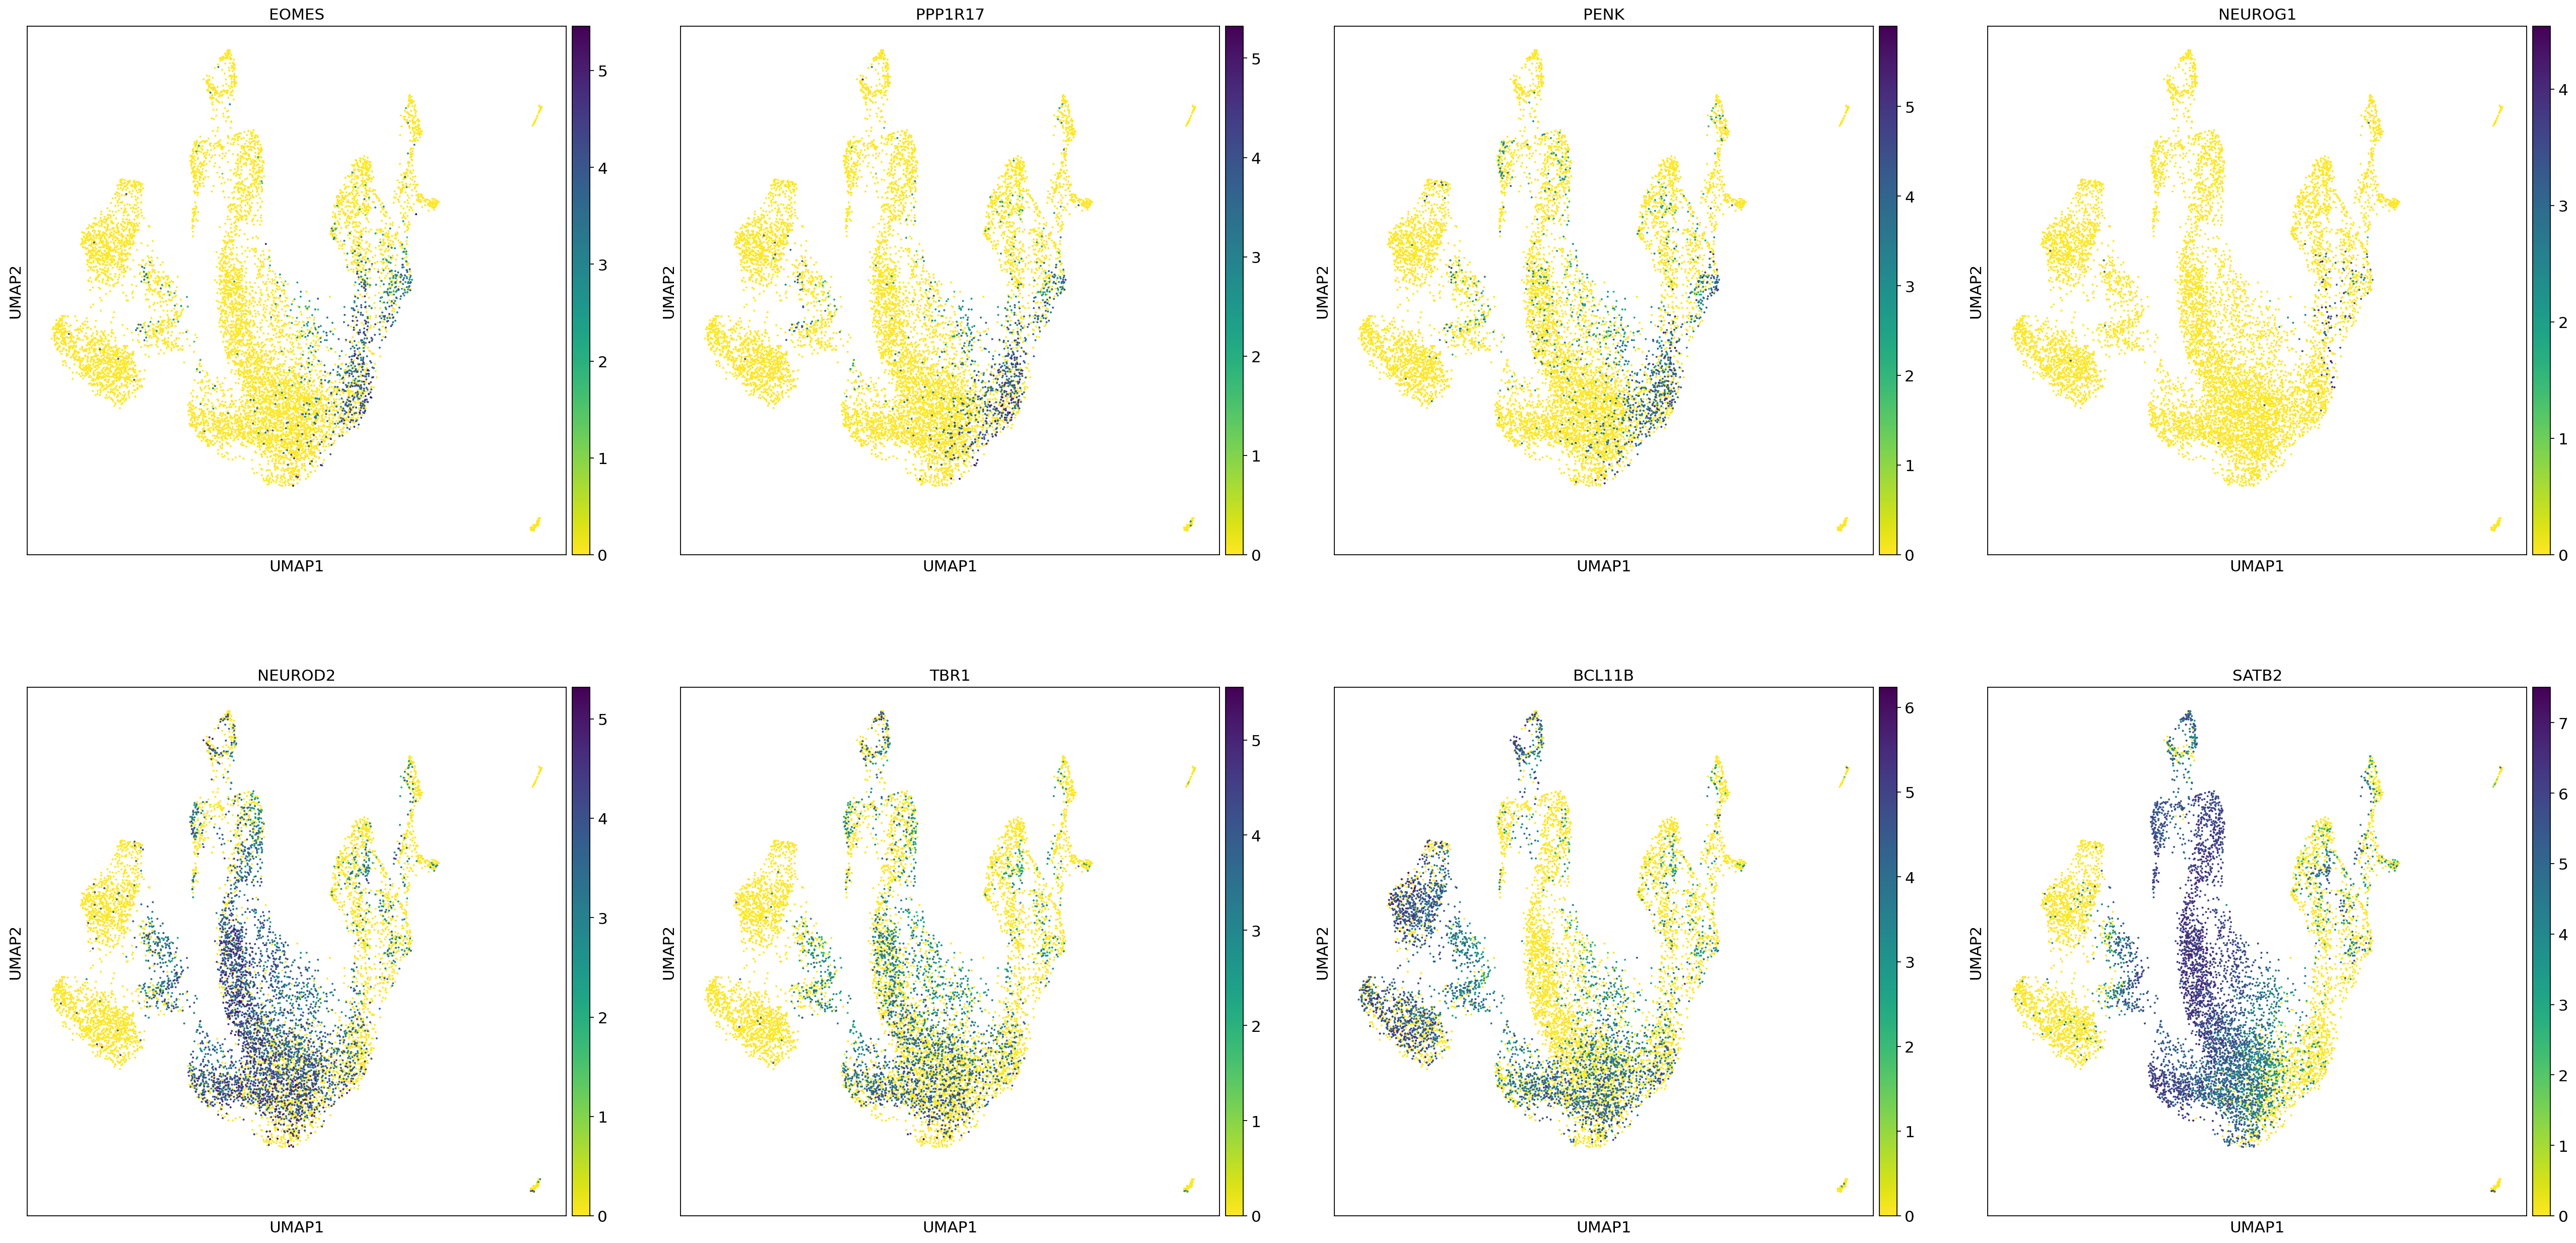

In [8]:
sc.pl.umap(mdata['rna'], color=marker_genes)

Then we need the genomic locations of genes. In this case we have saved this info in `mdata['rna'].var`. Alternatively, you can access genomic position of genes using `pyensembl`.

In [9]:
## Get all gene ranges from Ensembl
# from pyensembl import EnsemblRelease
# def ens_genes2df(genes):
#     '''
#     Convert pyemsembl genes to feature 
#     dataframe readable by muon
#     '''
#     genes_df = pd.DataFrame()
#     genes_df['Chromosome'] = ["chr" + x.contig for x in genes]
#     genes_df['Start'] = [x.start for x in genes]
#     genes_df['End'] = [x.end for x in genes]
#     genes_df['GeneName'] = [x.gene_name for x in genes]
#     genes_df['GeneID'] = [x.gene_id for x in genes]
#     return(genes_df)

# data = EnsemblRelease(77)
# gene_names = data.genes()
# genes_df = ens_genes2df(gene_names)

genes_df = mdata['rna'].var[['Chromosome', "Start", "End", "GeneName", 'GeneID']]
marker_genes_df = genes_df[genes_df['GeneName'].isin(marker_genes)]

## Find peaks within 10kb of genes
marker_genes_df['peak_IDs'] = np.nan 
for i in np.arange(marker_genes_df.shape[0]):
    gene_peaks = peaks2gene(marker_genes_df.GeneID.iloc[i], mdata['atac'].var, all_genes_df=genes_df, win_size=10000)
    marker_genes_df.loc[marker_genes_df.index[i], 'peak_IDs'] = ",".join(gene_peaks)

/tmp/ipykernel_9172/1802682562.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker_genes_df['peak_IDs'] = np.nan
/tmp/ipykernel_9172/1802682562.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker_genes_df.loc[marker_genes_df.index[i], 'peak_IDs'] = ",".join(gene_peaks)


In [10]:
marker_genes_df

Chromosome        Start          End GeneName           GeneID  \
TBR1          chr2  161416094.0  161425870.0     TBR1  ENSG00000136535   
SATB2         chr2  199269500.0  199471266.0    SATB2  ENSG00000119042   
EOMES         chr3   27715949.0   27722711.0    EOMES  ENSG00000163508   
NEUROG1       chr5  135534282.0  135535949.0  NEUROG1  ENSG00000181965   
PPP1R17       chr7   31686715.0   31708455.0  PPP1R17  ENSG00000106341   
PENK          chr8   56436674.0   56446734.0     PENK  ENSG00000181195   
BCL11B       chr14   99169287.0   99271524.0   BCL11B  ENSG00000127152   
NEUROD2      chr17   39603536.0   39609777.0  NEUROD2  ENSG00000171532   

                                                  peak_IDs  
TBR1     67889,67890,67891,67892,67893,67894,67895,6789...  
SATB2    73802,73803,73810,73817,73818,73823,73826,7382...  
EOMES    87203,87204,87205,87206,87207,87208,87209,8721...  
NEUROG1  157656,157657,157658,157659,157660,157661,1576...  
PPP1R17  200872,200873,200874,200875,200876,200877,2008...  
PENK             229284,229285,229286,229287,229288,229290  
BCL11B   363297,363302,363303,363304,363305,363306,3633...  
NEUROD2  403085,403086,403087,403088,403089,403090,4030...

## Smoothing gene expression and accessibility profiles

For feature-wise analysis, data is frequently denoised using KNN imputation, where we substitute the profile of a cell with the average profile of the cell and its k nearest neighbors.

In [11]:
def knn_smoothing(X_features, connectivities):
    '''
    Transform cell profile to average profile of neighbors
    
    params:
    -------
    - X_features: sparse matrix of dimensions cells x features to denoise
    - connectivities: connectivity matrix for KNN graph of dimensions cells x cells
    '''
    X_imputed = (
        scipy.sparse.csr_matrix.dot(connectivities.T, X_features)
        .astype(np.float32)
    )
    if scipy.sparse.issparse(X_imputed):
        X_imputed = X_imputed.A
    with np.errstate(divide='ignore', invalid="ignore"):
        X_imputed = X_imputed / X_features.sum(1).reshape(X_features.shape[0], 1)
    X_imputed = np.array(X_imputed)
    X_imputed[np.isnan(X_imputed)] = 0
    X_imputed[np.isinf(X_imputed)] = 0
    return(X_imputed)

In [12]:
## Select KNN graph to use for smoothing
connectivities = mdata.obsp["mofa_connectivities"]

## Subset adata to peaks and gene of interest
all_peaks_oi = list(set(sum([x.split(",") for x in marker_genes_df.peak_IDs.tolist()],[])))
sdata_atac = mdata['atac'][:, all_peaks_oi].copy()
sdata_rna = mdata['rna'][:,marker_genes_df.GeneName.tolist()].copy()

## Run KNN smoothing on accessibility profiles
X_acc = sdata_atac.X.copy()
sdata_atac.layers['X_smooth'] = knn_smoothing(X_acc, connectivities)

X_gex = sdata_rna.X.copy()
sdata_rna.layers['X_smooth'] = knn_smoothing(X_gex, connectivities)

### Question 1

Does the choice of KNN graph affect the imputation for these genes and peaks? e.g. do you get significantly different imputation if you use the connectivity from the KNN graph computed on the single modalities? What about the number of neighbors (k)? Remember you can always recompute the KNN graphs with `sc.pp.neighbors` increasing the `n_neighbors` parameter 
 

## Compute correlation between expression and accessibility
To test for correlation between gene expression and chromatin accessibility, a common approach is to compute a gene-peak correlation coefficient (Spearman ⍴ or Pearson R2) by correlating normalized scATAC-seq peak peak counts with the corresponding gene’s expression across all ATAC-RNA paired cells. Then the observed coefficient for each gene-peak pair is compared to the coefficients obtained matching the gene to "background peaks" with matching total accessibility and GC content to the tested one, accounting for technical biases between cells that are caused by PCR amplification or variable Tn5 tagmentation conditions. This results in a null peak-gene correlation distribution that is independent of peak-gene proximity, that can be used for significance testing (for references describing this method see [Ma et al. 2020](https://www.cell.com/cell/fulltext/S0092-8674(20)31253-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420312538%3Fshowall%3Dtrue) or [Kartha et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.28.453784v1.full)).

There is no one-stop-shop package to test for these associations and here we are going to use a custom python implementation to understand the different steps better. Alternative implementations in R and python include:  

- The [ArchR]() package provides a [`Peak2GeneLinkage`](https://www.archrproject.com/bookdown/peak2genelinkage-with-archr.html) function to perform a similar mapping (however this only works if you follow their RNA-ATAC integration pipeline from start to finish).
- [Code from Buenrostro lab](https://github.com/buenrostrolab/stimATAC_analyses_code).
- [SEAcells]()

In [13]:
## Assign peaks to GC bias and count bins for sampling of background peaks 
mdata['atac'].var['GC_bin'] = pd.cut(mdata['atac'].var['GCbias'], bins=np.arange(0,1,0.05))
mdata['atac'].var['count_bin'] = pd.cut(mdata['atac'].var['n_cells_by_counts'], bins=np.arange(0, mdata['atac'].var['n_cells_by_counts'].max(), 100))

sdata_atac.var['GC_bin'] = mdata['atac'].var.loc[sdata_atac.var_names, 'GC_bin']
sdata_atac.var['count_bin'] = mdata['atac'].var.loc[sdata_atac.var_names, 'count_bin']

In [39]:
## Define number of background peaks to sample for each peak
n_rand_sample = 30

In [40]:
from scipy.stats import rankdata
from sklearn.metrics import pairwise_distances
import gc ## for RAM cleaning

gene2peak_cor_df = pd.DataFrame()
for i in np.arange(marker_genes_df.shape[0]):
    gene_name = marker_genes_df.iloc[i]['GeneName']
    peaks_ids = marker_genes_df.iloc[i]['peak_IDs'].split(',')
    print(f'Testing associations to {gene_name}...')
    
    X_gex_smooth = sdata_rna[:,gene_name].layers['X_smooth'].copy()
    X_acc_smooth = sdata_atac[:,peaks_ids].layers['X_smooth'].copy()

    ## Compute correlations of gene to true peaks
    cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X_acc_smooth.T),
                                           rankdata(X_gex_smooth.T).reshape(
                                               1, -1),
                                           metric='correlation'))
    cors = pd.Series(cors, index = peaks_ids)
    df = pd.DataFrame(1.0, index = peaks_ids, columns=['cor', 'pval'])
    df['gene'] = gene_name
    df['cor'] = cors

    ## Sample background peaks
    for p in peaks_ids:  
        try:
            # Try random sampling without replacement
            rand_peaks = np.random.choice(mdata['atac'].var_names[(mdata['atac'].var['GC_bin'] == mdata['atac'].var['GC_bin'][p]) &
                                                             (mdata['atac'].var['count_bin'] == mdata['atac'].var['count_bin'][
                                                                 p])], n_rand_sample, False)
        except:
            rand_peaks = np.random.choice(mdata['atac'].var_names[(mdata['atac'].var['GC_bin'] == mdata['atac'].var['GC_bin'][p]) &
                                                             (mdata['atac'].var['count_bin'] == mdata['atac'].var['count_bin'][
                                                                 p])], n_rand_sample, True)

        ## Get smooth accessibility for background peaks
        sdata_bg = mdata['atac'][:, rand_peaks].copy()
        X_acc_smooth_bg = knn_smoothing(sdata_bg.X, connectivities)

        ## Compute correlations to background peaks
        rand_cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X_acc_smooth_bg.T),
                                               rankdata(X_gex_smooth.T).reshape(
                                                   1, -1),
                                               metric='correlation'))
        rand_cors = pd.Series(rand_cors, index = rand_peaks)

        ## Compute Z test pval
        m = np.mean(rand_cors)
        v = np.std(rand_cors)

        from scipy.stats import norm
        df.loc[p, 'pval'] = 1 - norm.cdf(cors[p], m, v)
        gene2peak_cor_df = pd.concat([gene2peak_cor_df, df])
        gc.collect()

Testing associations to TBR1...
Testing associations to SATB2...
Testing associations to EOMES...
Testing associations to NEUROG1...
Testing associations to PPP1R17...
Testing associations to PENK...
Testing associations to BCL11B...
Testing associations to NEUROD2...


In [92]:
gene2peak_cor_df.index.name = 'peak_id'
gene2peak_cor_df.reset_index(inplace=True)

## Correct for multiple testing with BH
p_vals = gene2peak_cor_df['pval'].values
ranked_p_values = rankdata(p_vals)
fdr = p_vals * len(p_vals) / ranked_p_values
fdr[fdr > 1] = 1
gene2peak_cor_df['adj_pval'] = fdr

### Plot output

/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '-log10(Adj. Pval)')

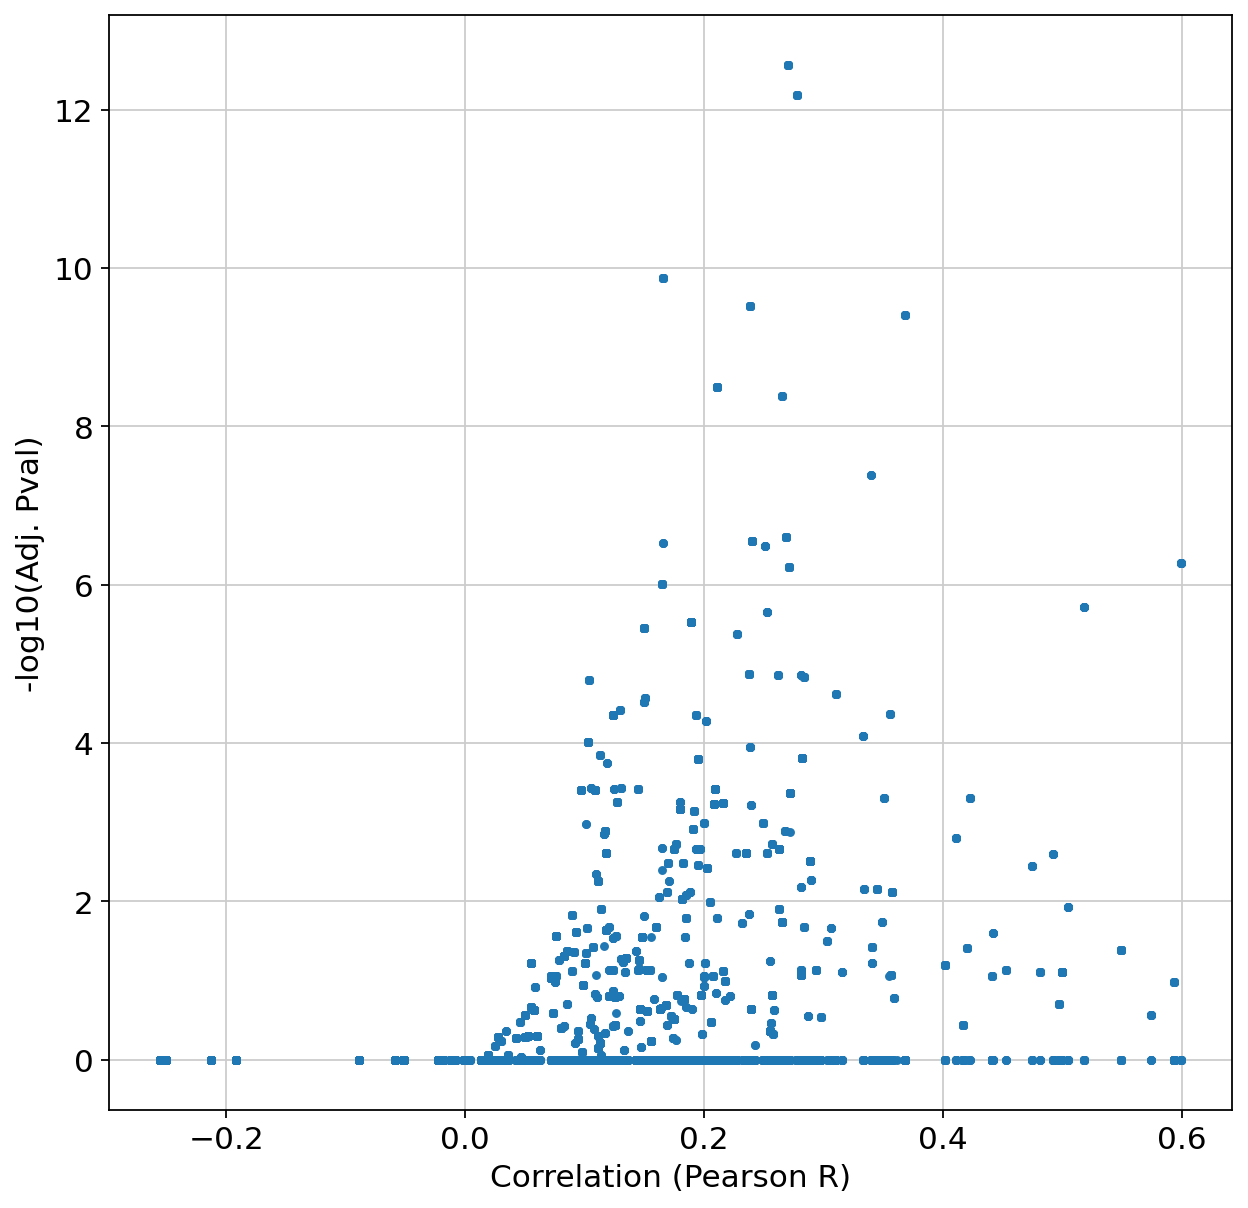

In [93]:
plt.plot(gene2peak_cor_df['cor'], -np.log10(gene2peak_cor_df['adj_pval']), '.');
plt.xlabel("Correlation (Pearson R)"); plt.ylabel('-log10(Adj. Pval)')

<AxesSubplot:xlabel='gene', ylabel='frac_peaks_signif'>

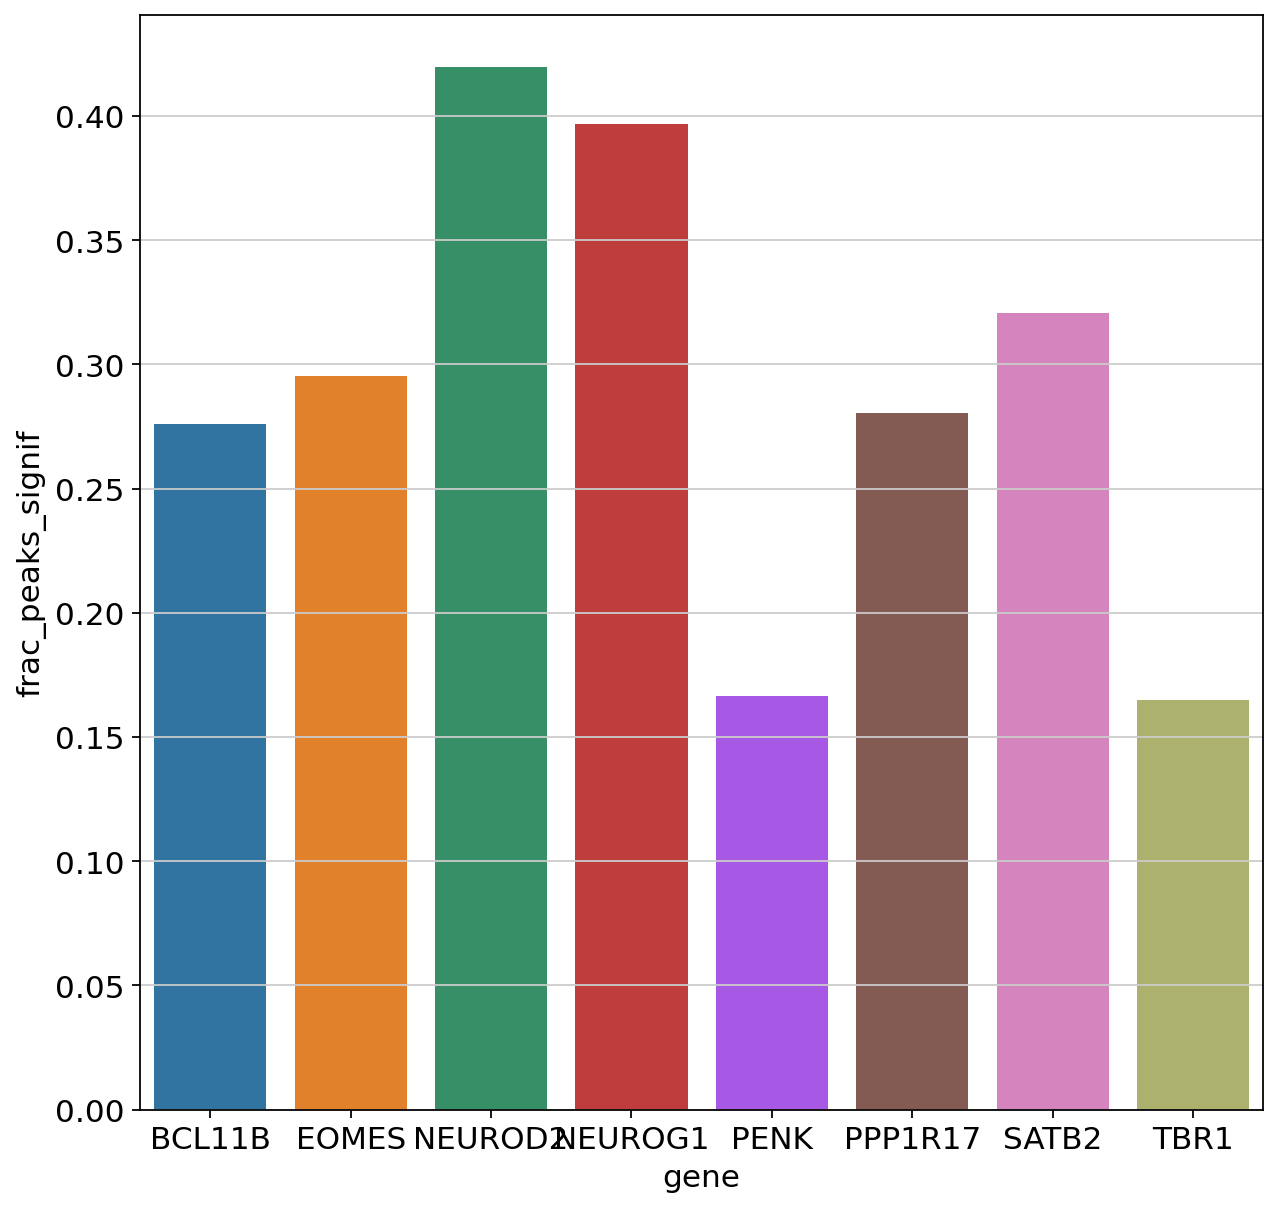

In [94]:
signif_gene2peak_cor_df = gene2peak_cor_df[gene2peak_cor_df.adj_pval < 0.1].copy()
n_signif_df = signif_gene2peak_cor_df.groupby('gene').size().reset_index()
n_signif_df.columns = ['gene', 'n_peaks_signif']
n_signif_df['n_peaks_tested'] = gene2peak_cor_df.groupby('gene').size().reset_index()[0]
n_signif_df['frac_peaks_signif'] = n_signif_df['n_peaks_signif']/n_signif_df['n_peaks_tested']
sns.barplot(data=n_signif_df, y='frac_peaks_signif', x='gene')

<AxesSubplot:xlabel='gene', ylabel='cor'>

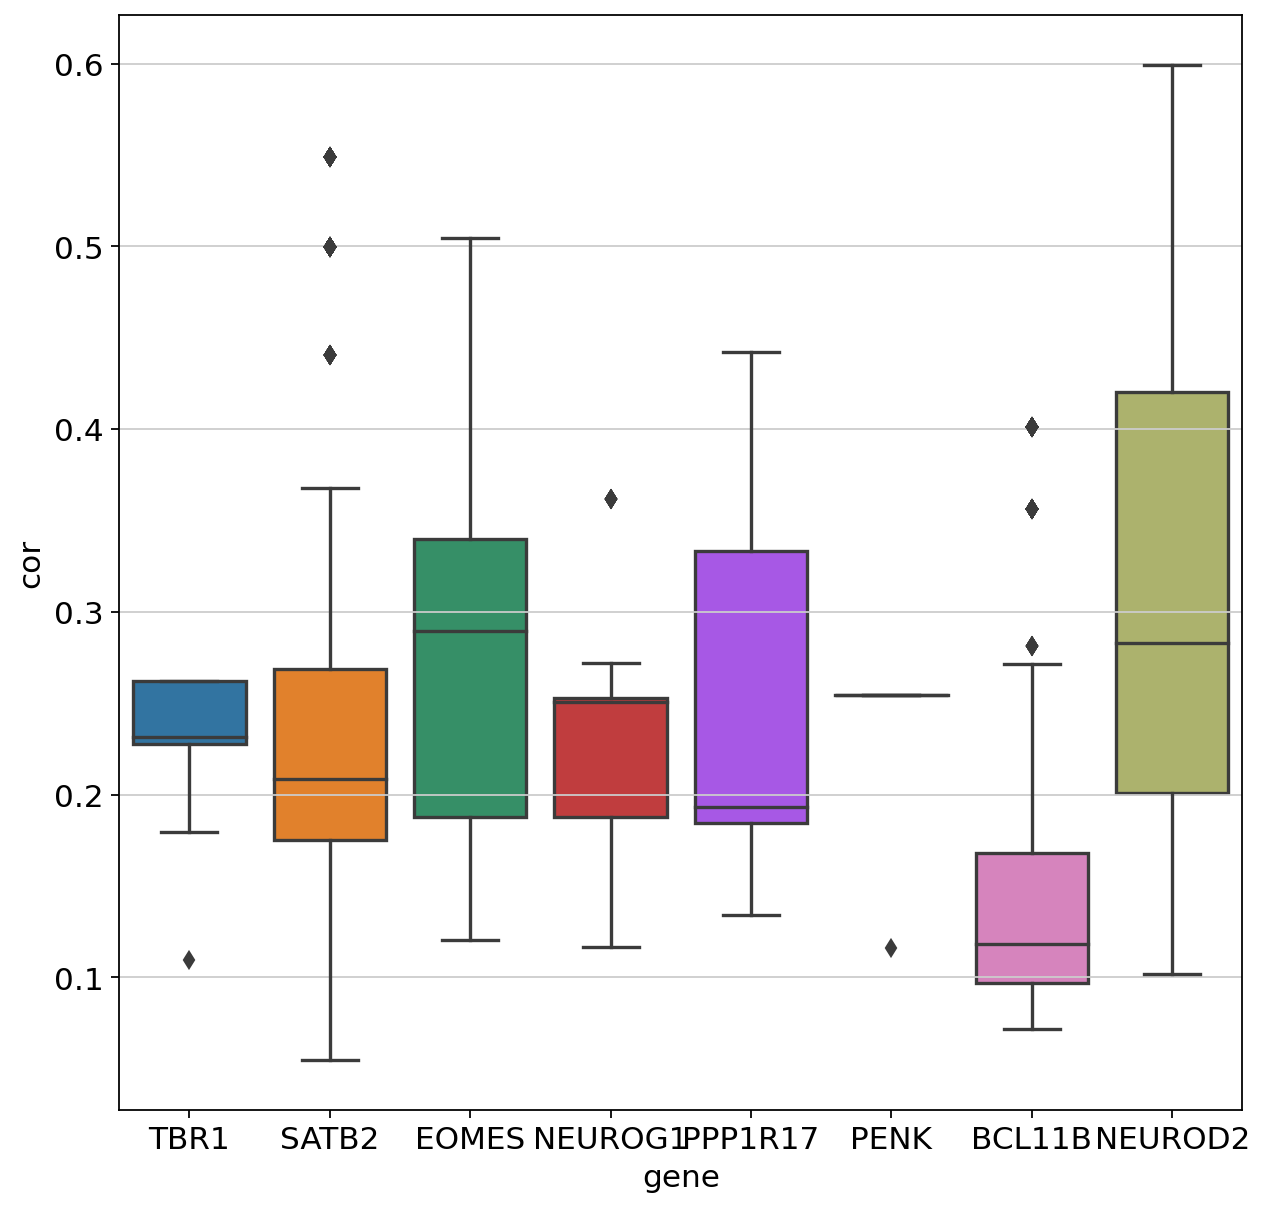

In [95]:
sns.boxplot(data=signif_gene2peak_cor_df, x='gene', y='cor')

In [96]:
signif_gene2peak_cor_df[signif_gene2peak_cor_df.cor > 0.3]

peak_id       cor          pval     gene      adj_pval
2243    73845  0.499567  2.174094e-02    SATB2  7.733553e-02
2339    73845  0.499567  2.174094e-02    SATB2  7.733553e-02
2435    73845  0.499567  2.174094e-02    SATB2  7.733553e-02
2531    73845  0.499567  2.174094e-02    SATB2  7.733553e-02
2627    73845  0.499567  2.174094e-02    SATB2  7.733553e-02
...       ...       ...           ...      ...           ...
19721  403104  0.599350  1.262458e-08  NEUROD2  5.386943e-07
19722  403105  0.473981  5.392101e-04  NEUROD2  3.573308e-03
19725  403108  0.491554  3.536023e-04  NEUROD2  2.524269e-03
19726  403109  0.332795  4.438876e-06  NEUROD2  8.058991e-05
19727  403110  0.517995  5.342034e-08  NEUROD2  1.887646e-06

[733 rows x 5 columns]

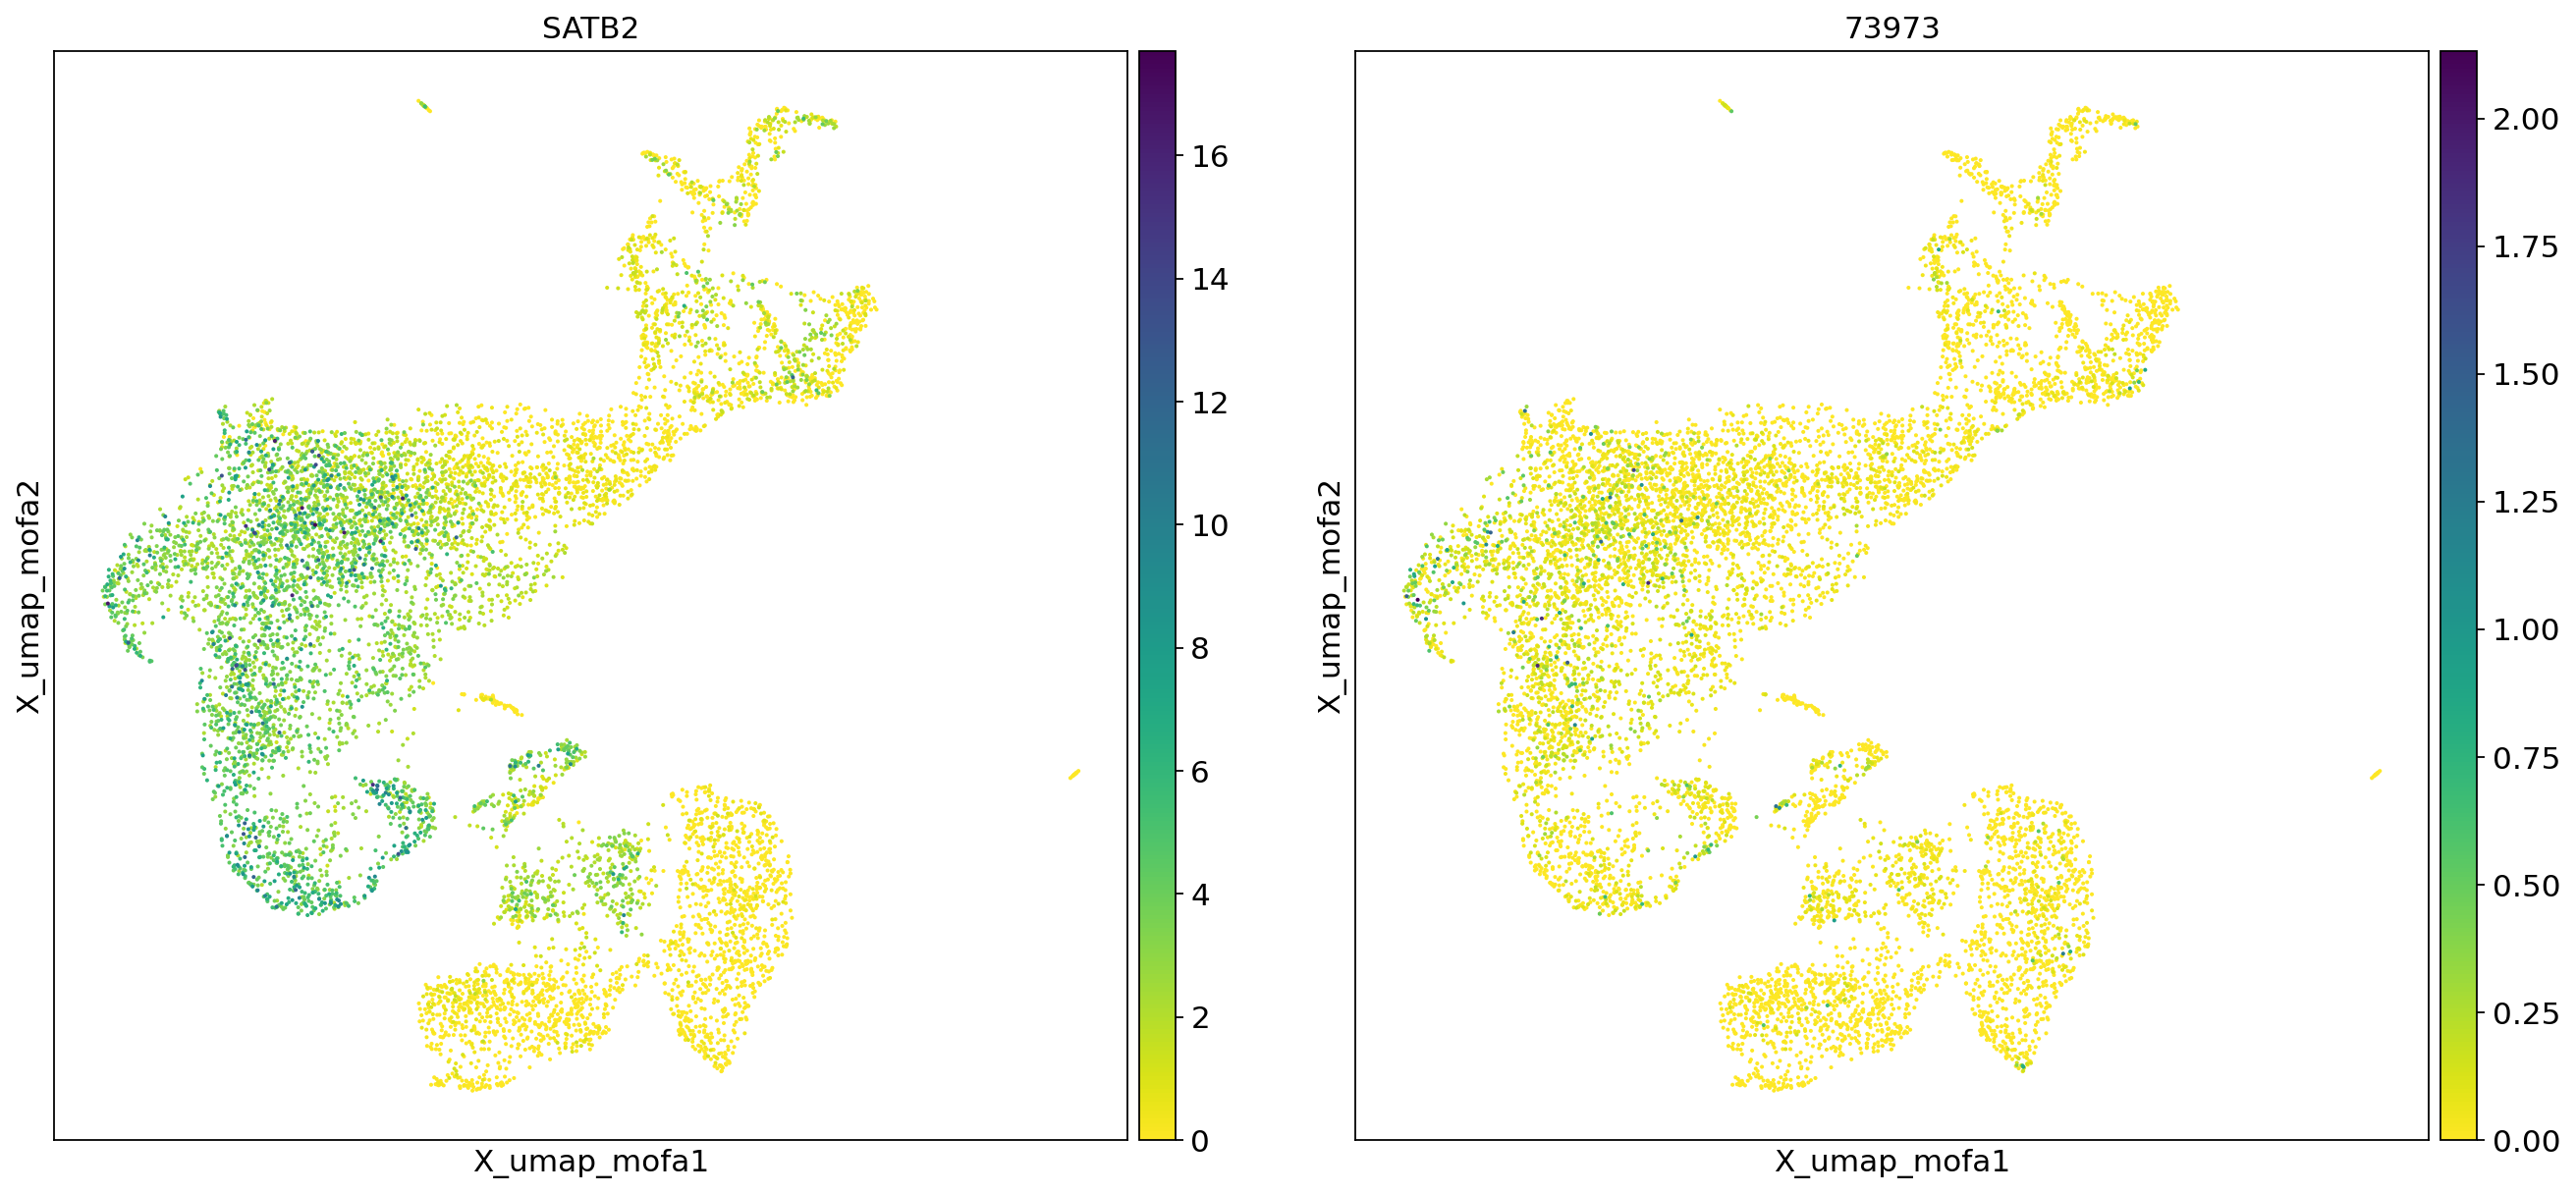

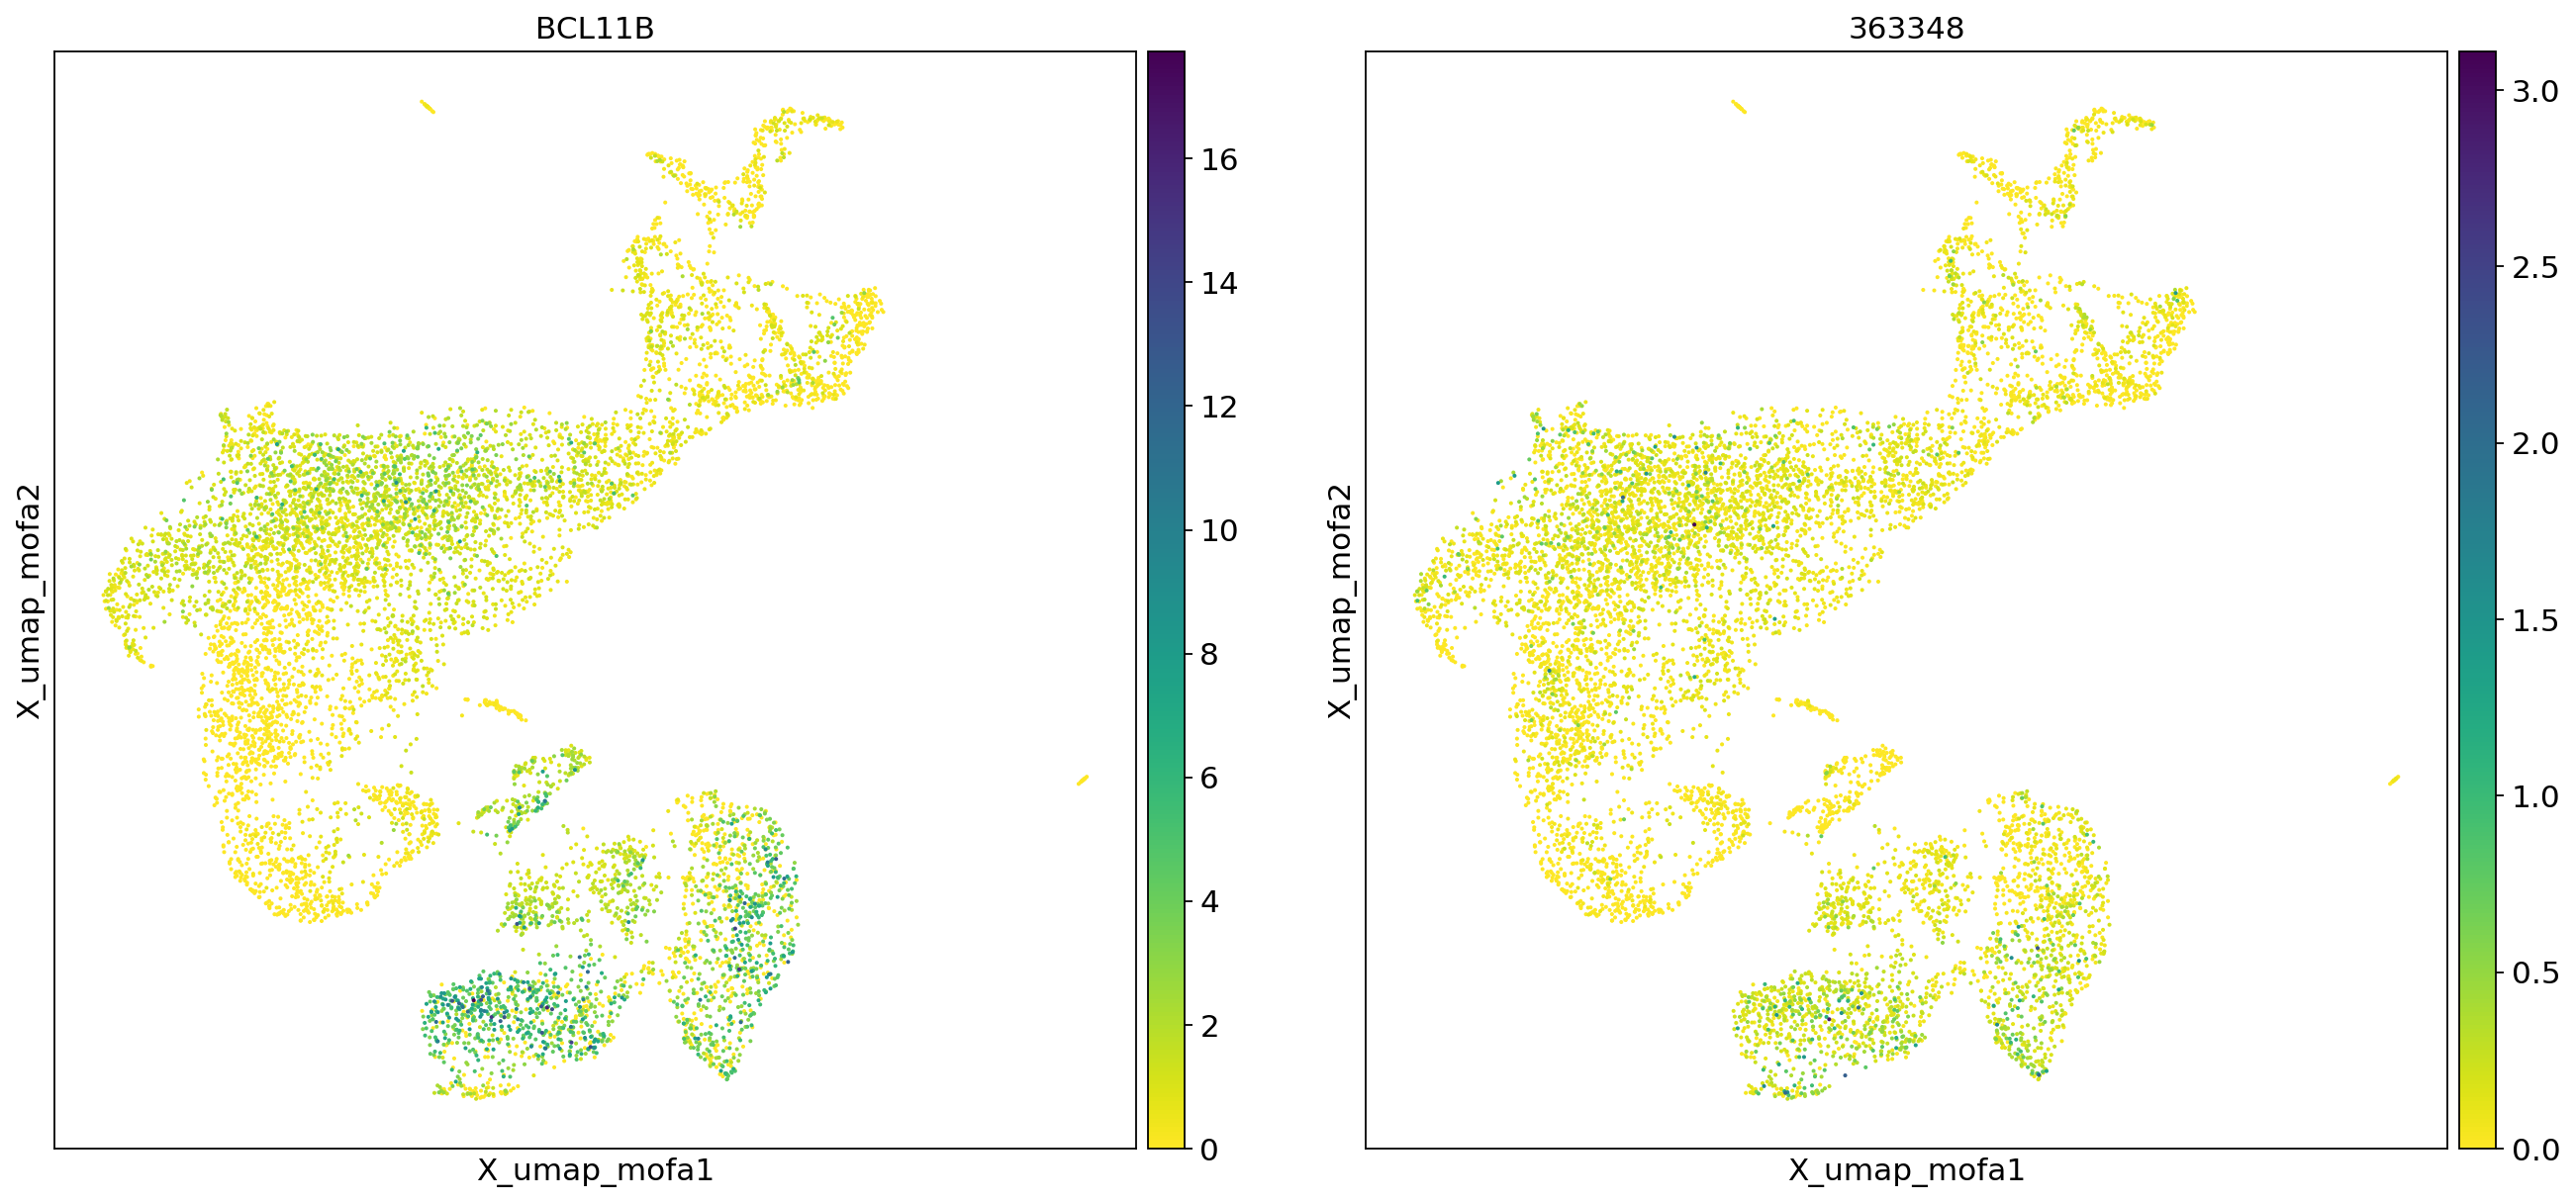

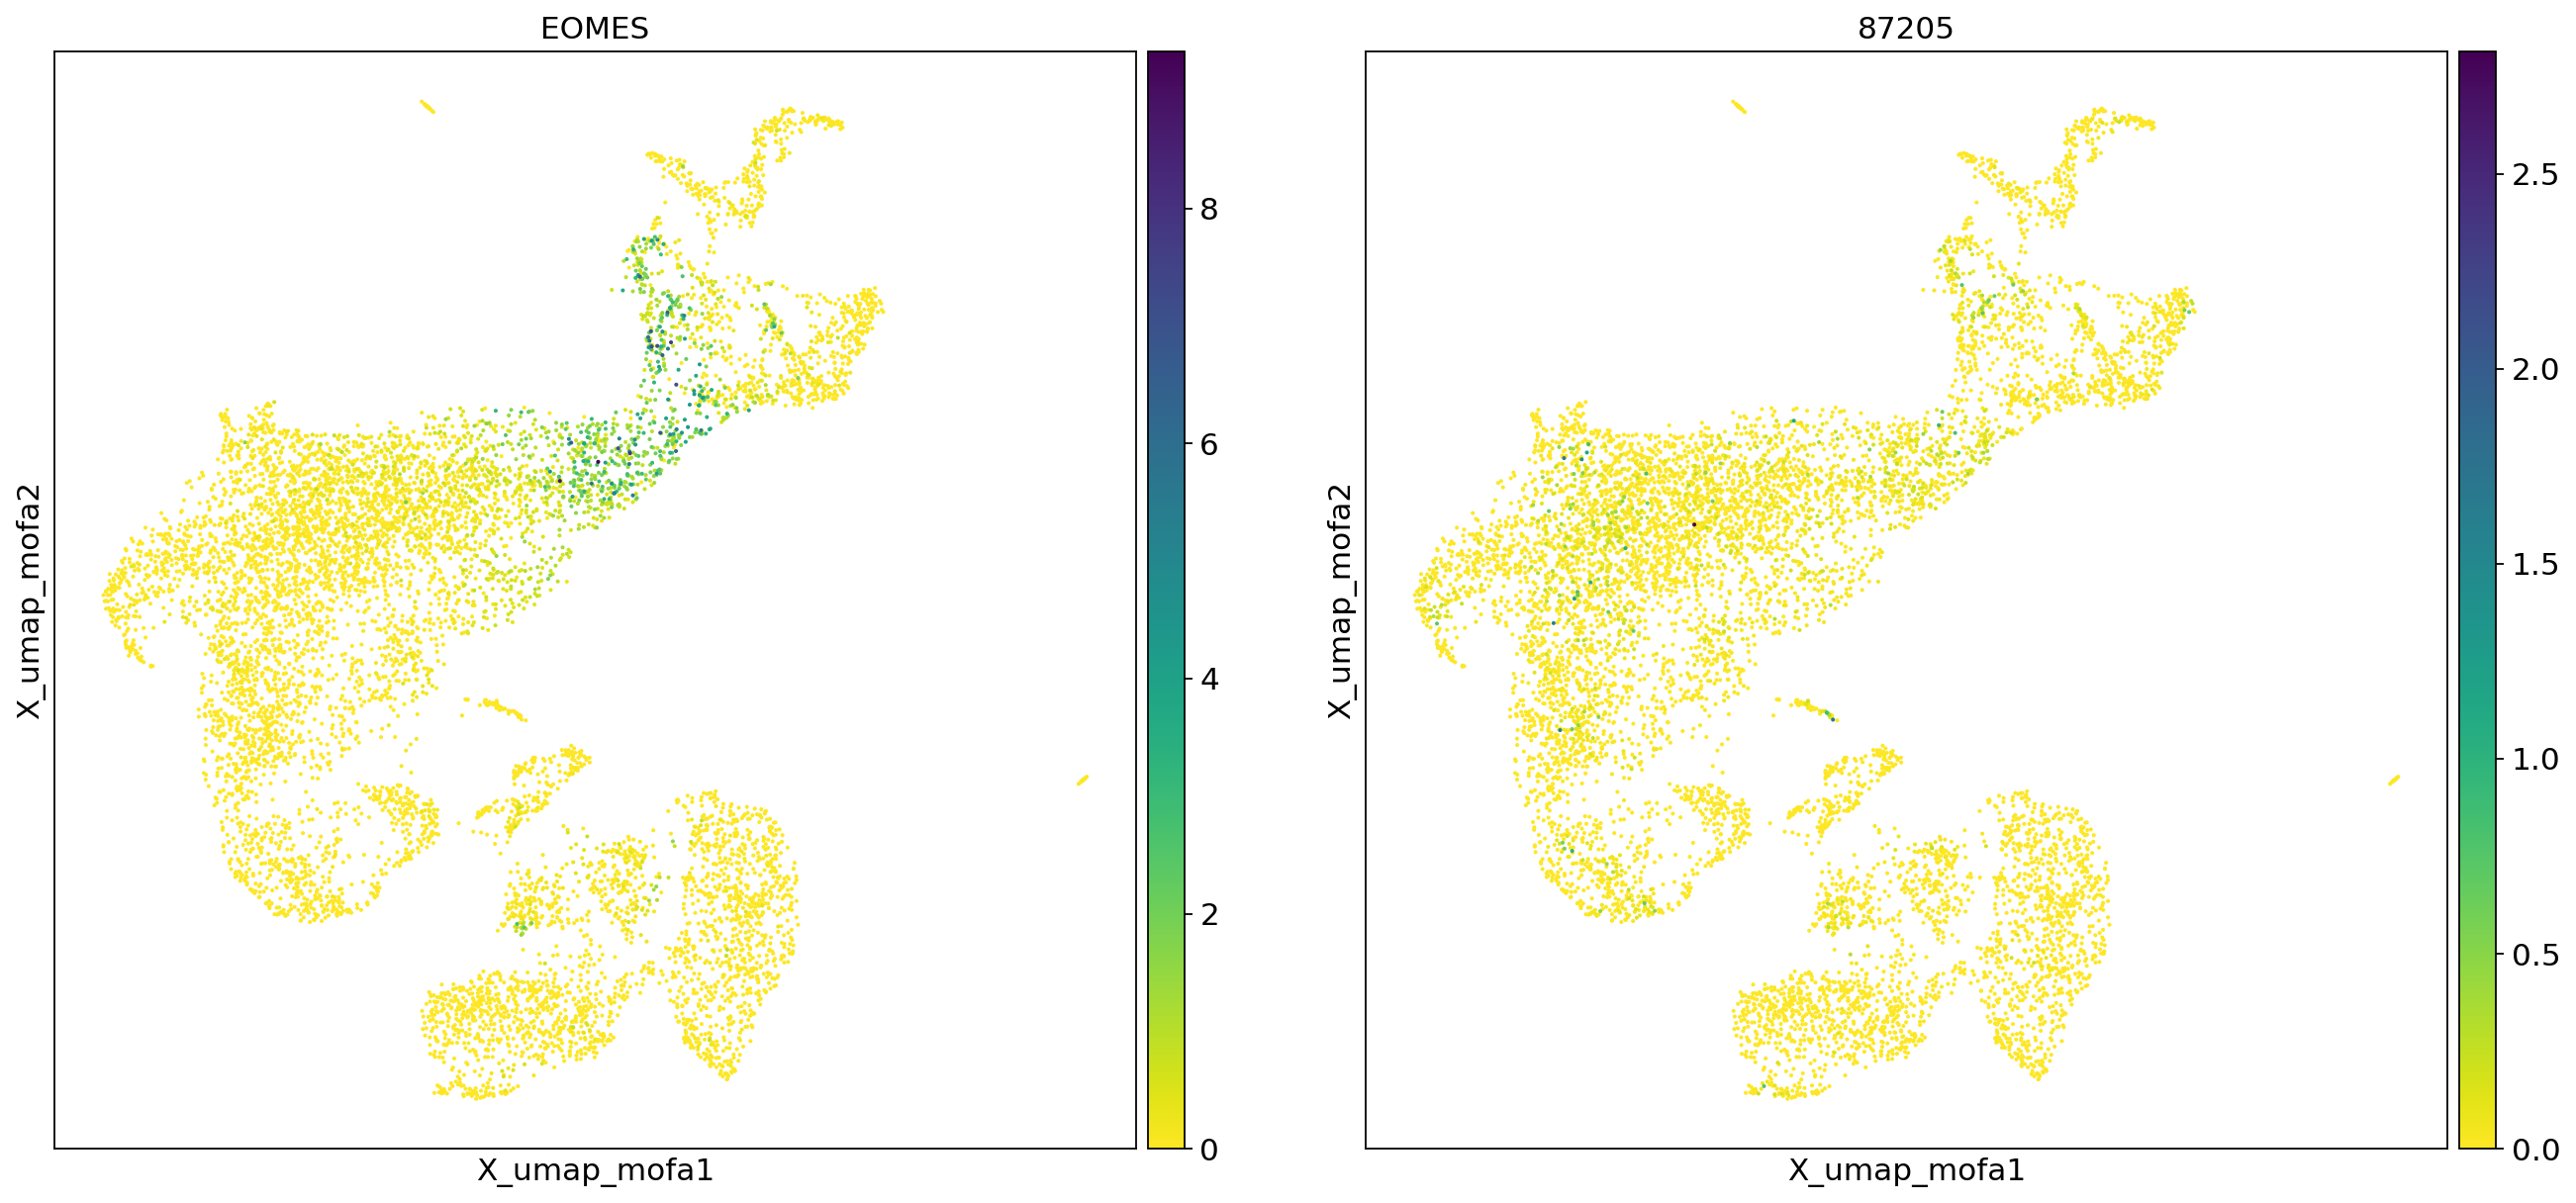

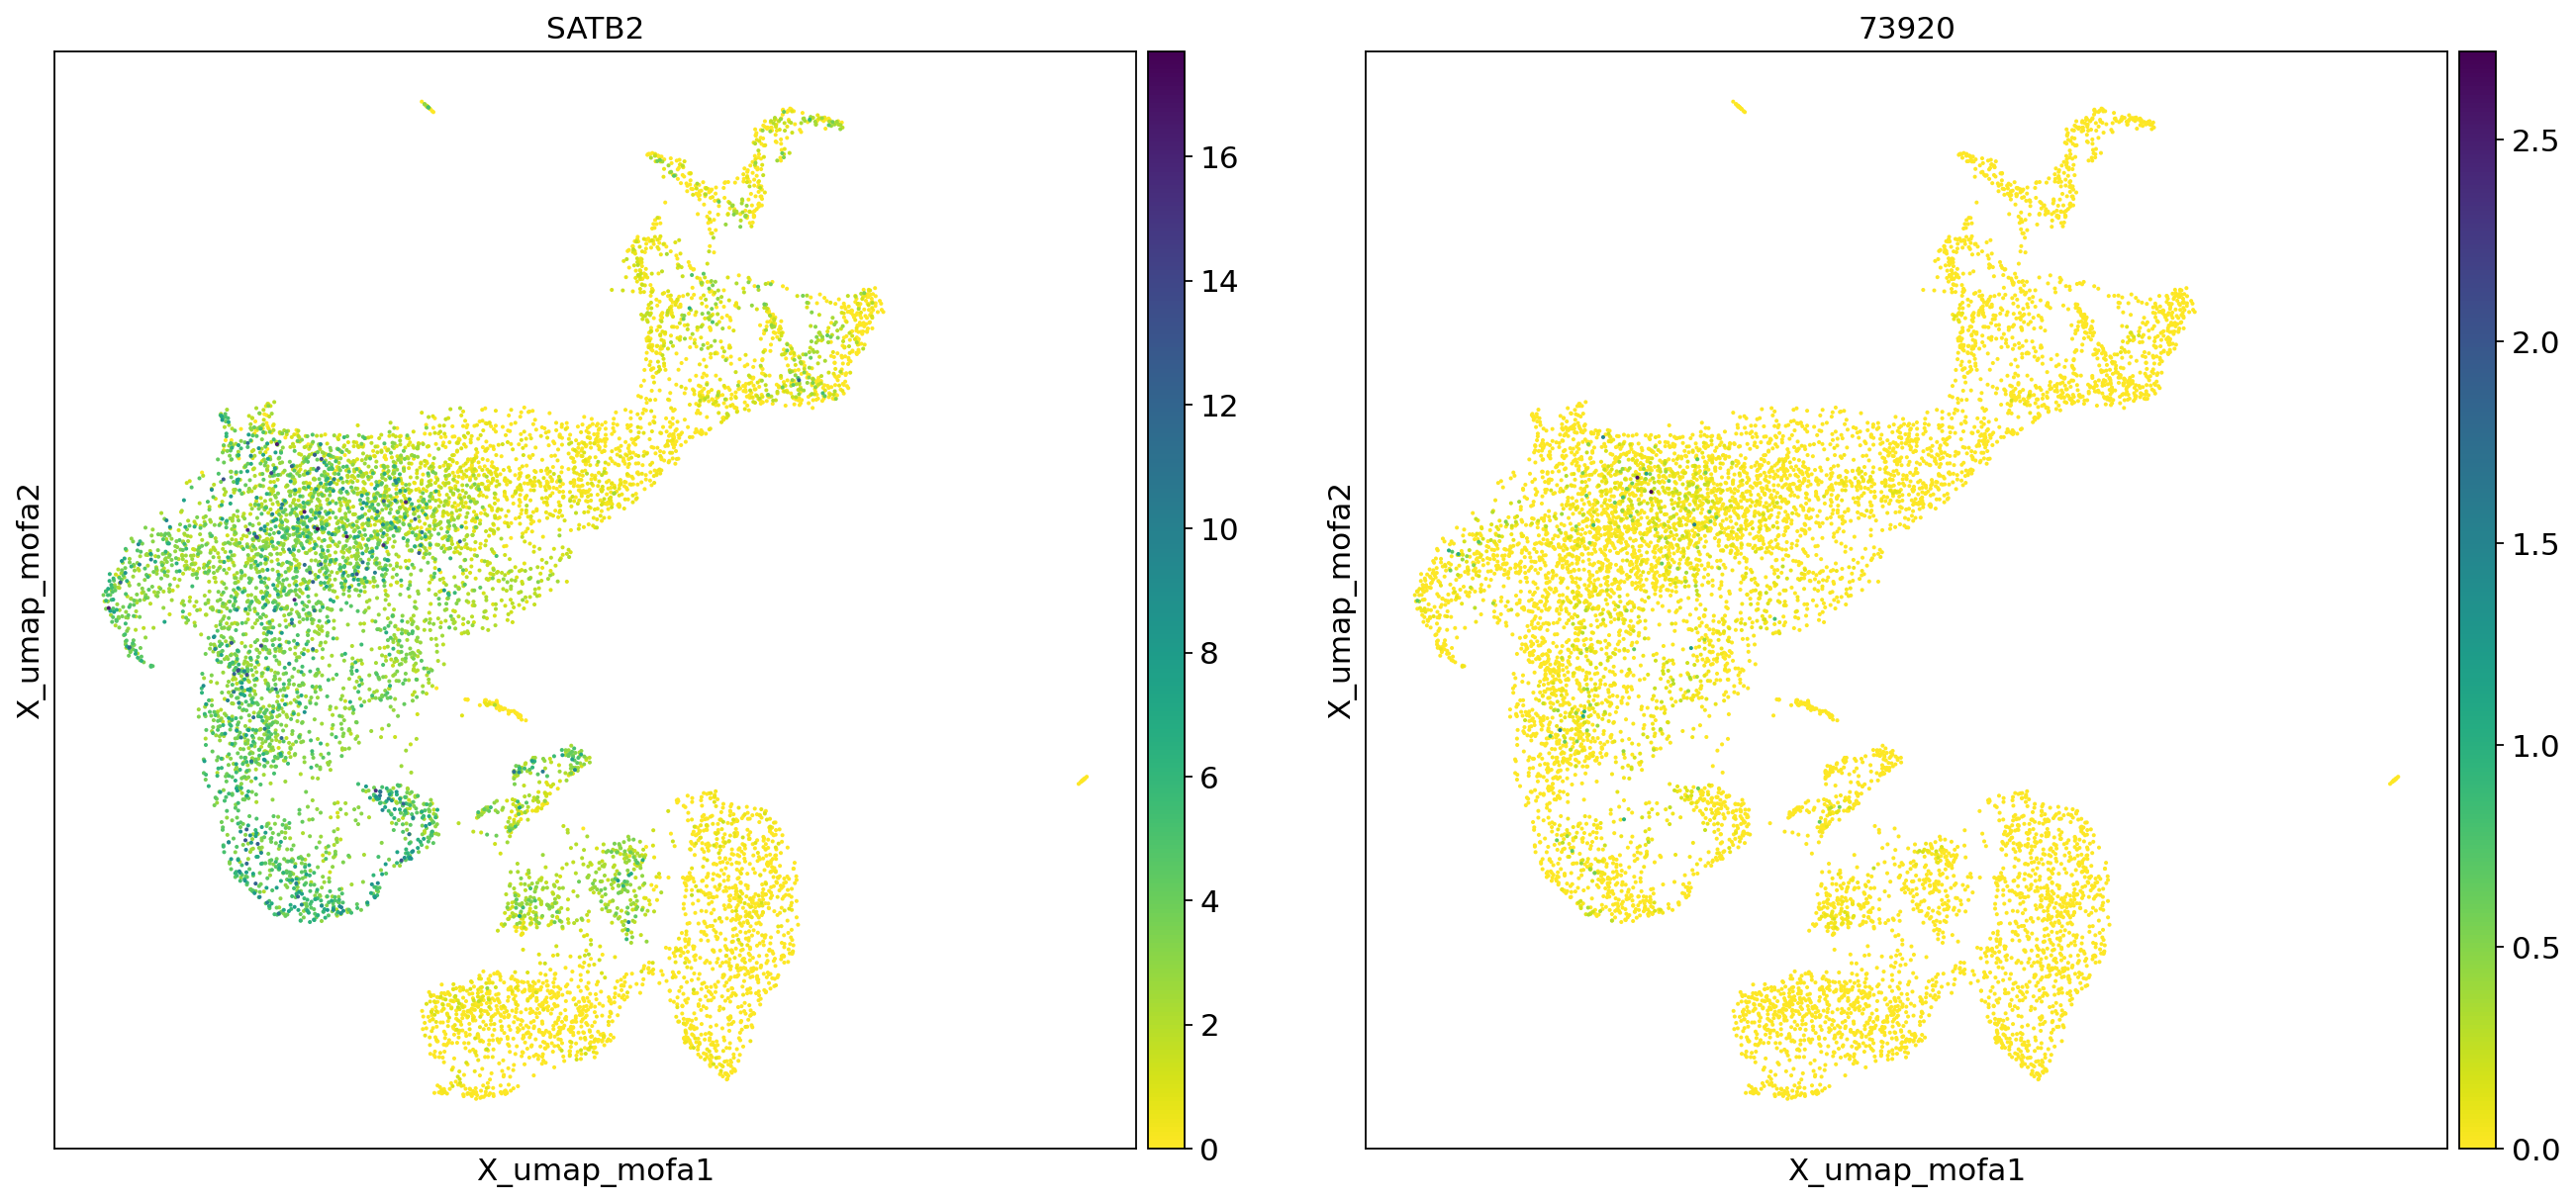

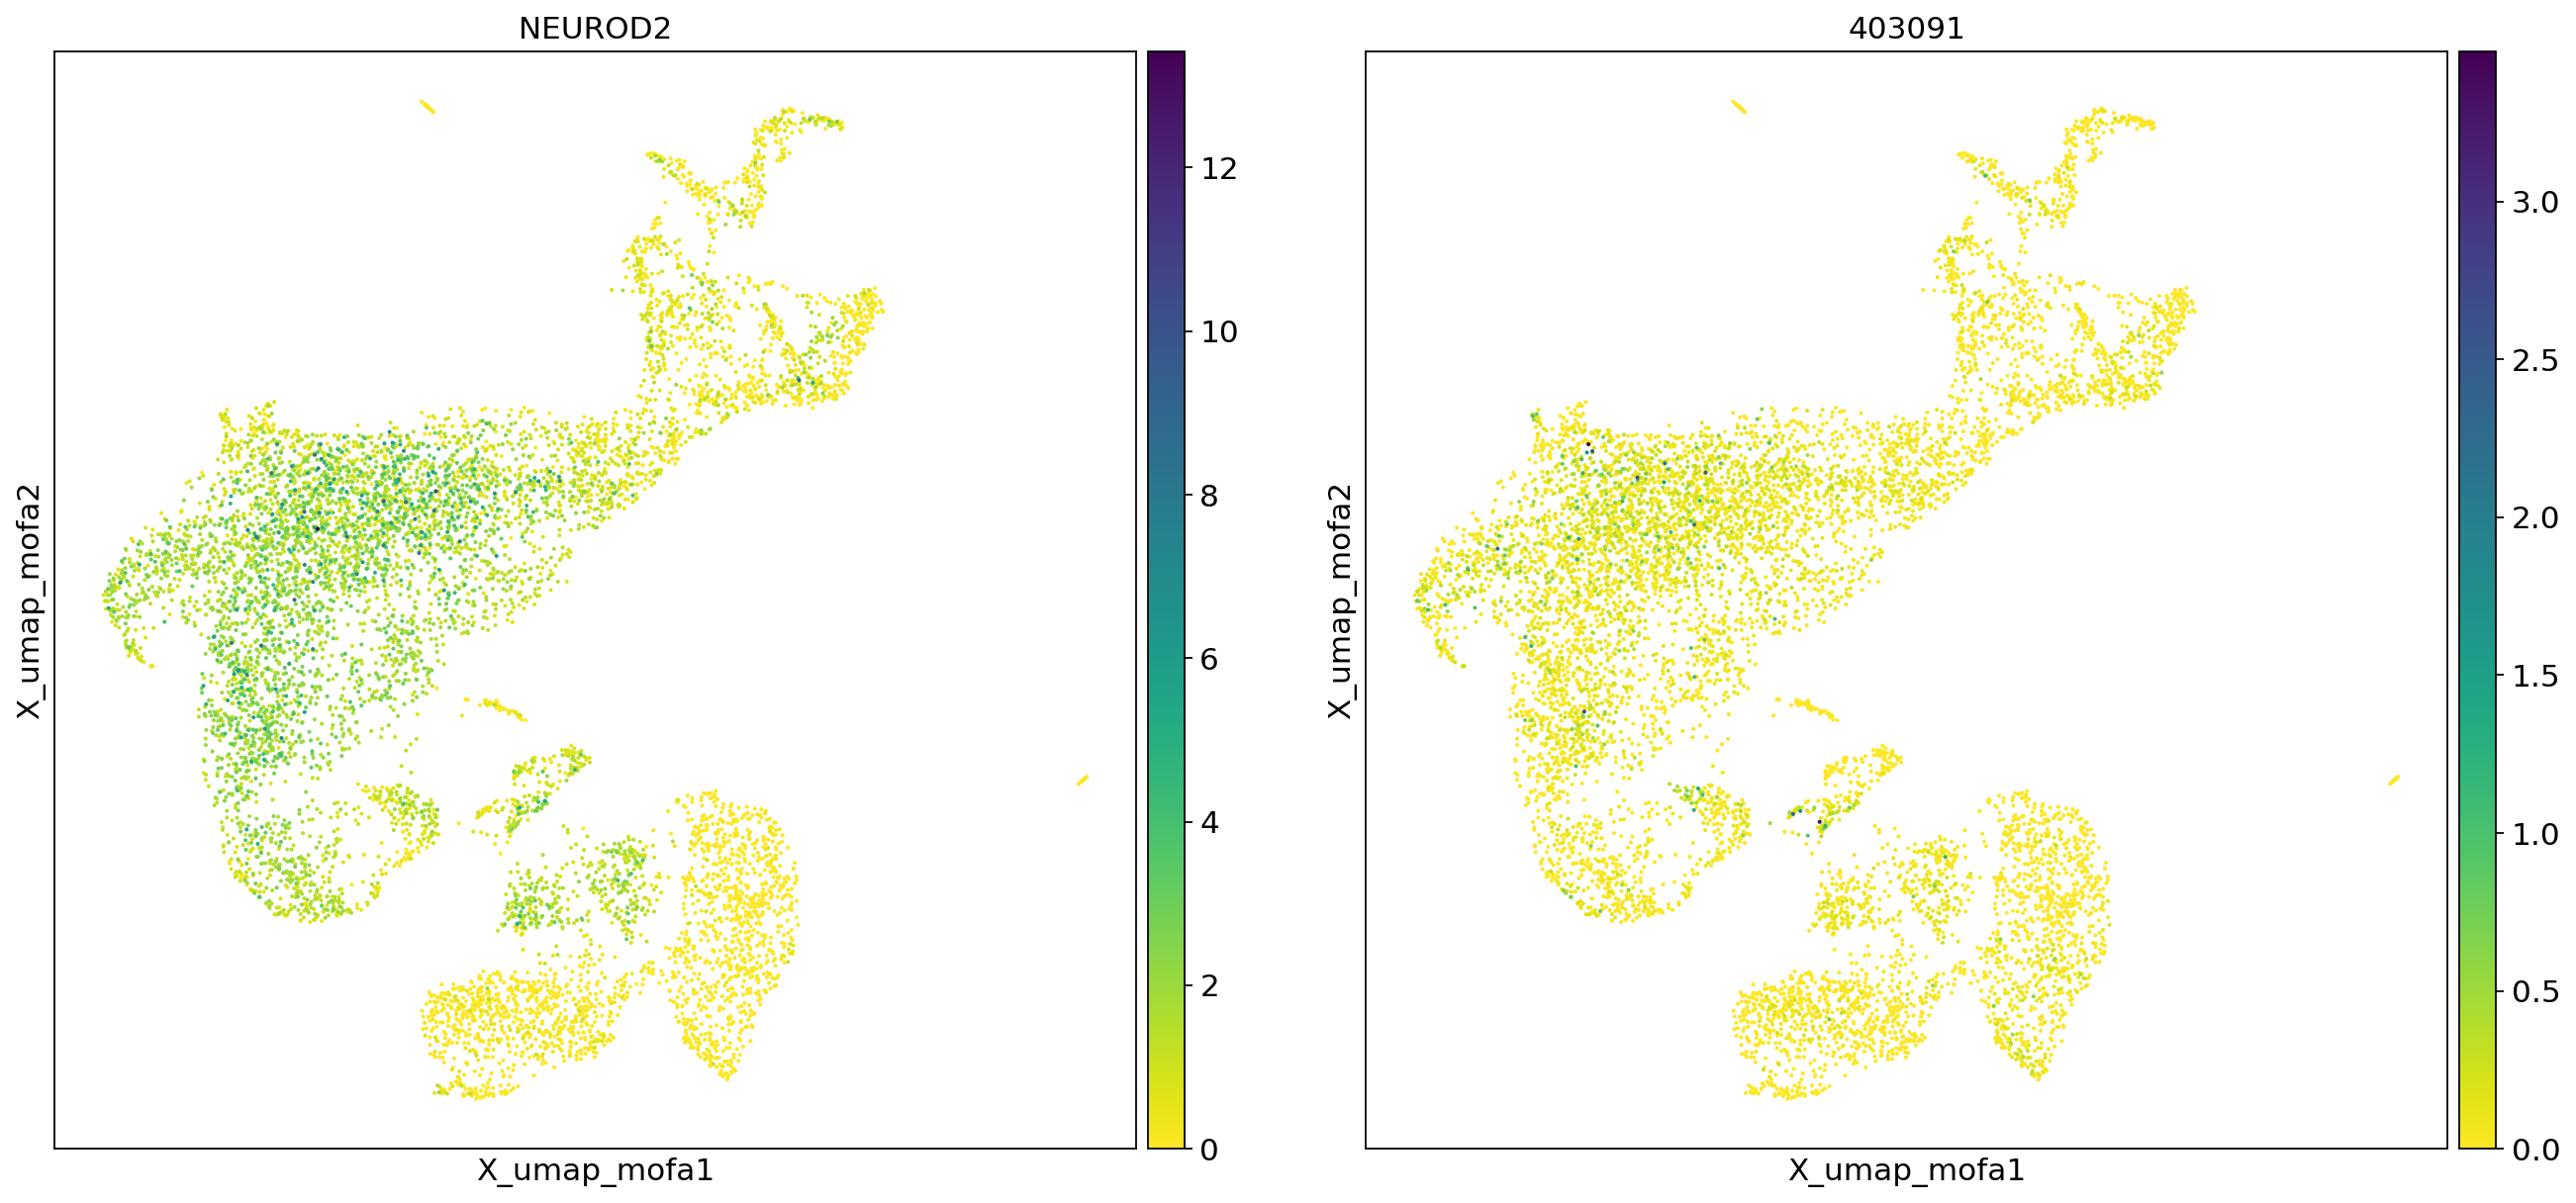

In [103]:
## Visualize example pairs on embedding
def plot_peak2gene(mdata, g, p, basis='X_umap_mofa', **kwargs):
    mdata.obs['g_expression'] = sdata_rna[:,g].layers['X_smooth'].toarray()
    mdata.obs['p_accessibility'] = sdata_atac[:,p].layers['X_smooth'].toarray()
    sc.pl.embedding(mdata, basis, color=['g_expression', 'p_accessibility'], title=(g,p), **kwargs)

smp_ixs = np.random.choice(signif_gene2peak_cor_df[signif_gene2peak_cor_df.cor > 0.3].index, 5) 
for i in smp_ixs:
    p = signif_gene2peak_cor_df.peak_id[i]
    g = signif_gene2peak_cor_df.gene[i]
    plot_peak2gene(mdata, g,p)


How can you assess that your predicted associations make sense? Some ideas:
- Use positive control: e.g. we expect that peaks in the proximity of Transcription Start Sites should be more frequently linked to gene expression.
- Can you define a set of "negative control pairs" where you _don't_ expect to see association?
- Are peaks associated to genes enriched in Transcription Factor motifs? Have a look at [muon helper functions](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.scan_sequences.html?highlight=motif) and [motifmatchr](http://bioconductor.org/packages/release/bioc/html/motifmatchr.html).